<a href="https://colab.research.google.com/github/fun-math/Team-6-ML-subsystem/blob/master/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import random
import os

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
colours=['Green','Navy_Blue','Cyan','Red','Yellow','Brown','Black','Grey']
h=192
b=256

## Initial Data Processing

In [ ]:
%cd '/content/drive/My Drive/Images/Base_new/'

/content/drive/.shortcut-targets-by-id/1imAlxk4WJhky2T06ANjkfoIGZY7vl8zX/Images/Base_new


In [ ]:
def load(img_name):
  img=cv2.imread(img_name,0)
  img=cv2.resize(img,(960,540))
  #img_new=img[297-110:297+40,500-65:500+135]
  img_new=img[150:450,330:730]
  img_new=cv2.resize(img_new,(b,h))
  img_new=img_new.reshape(h,b,1)
  return img_new

#img_new=img[106:488,245:754],297,500

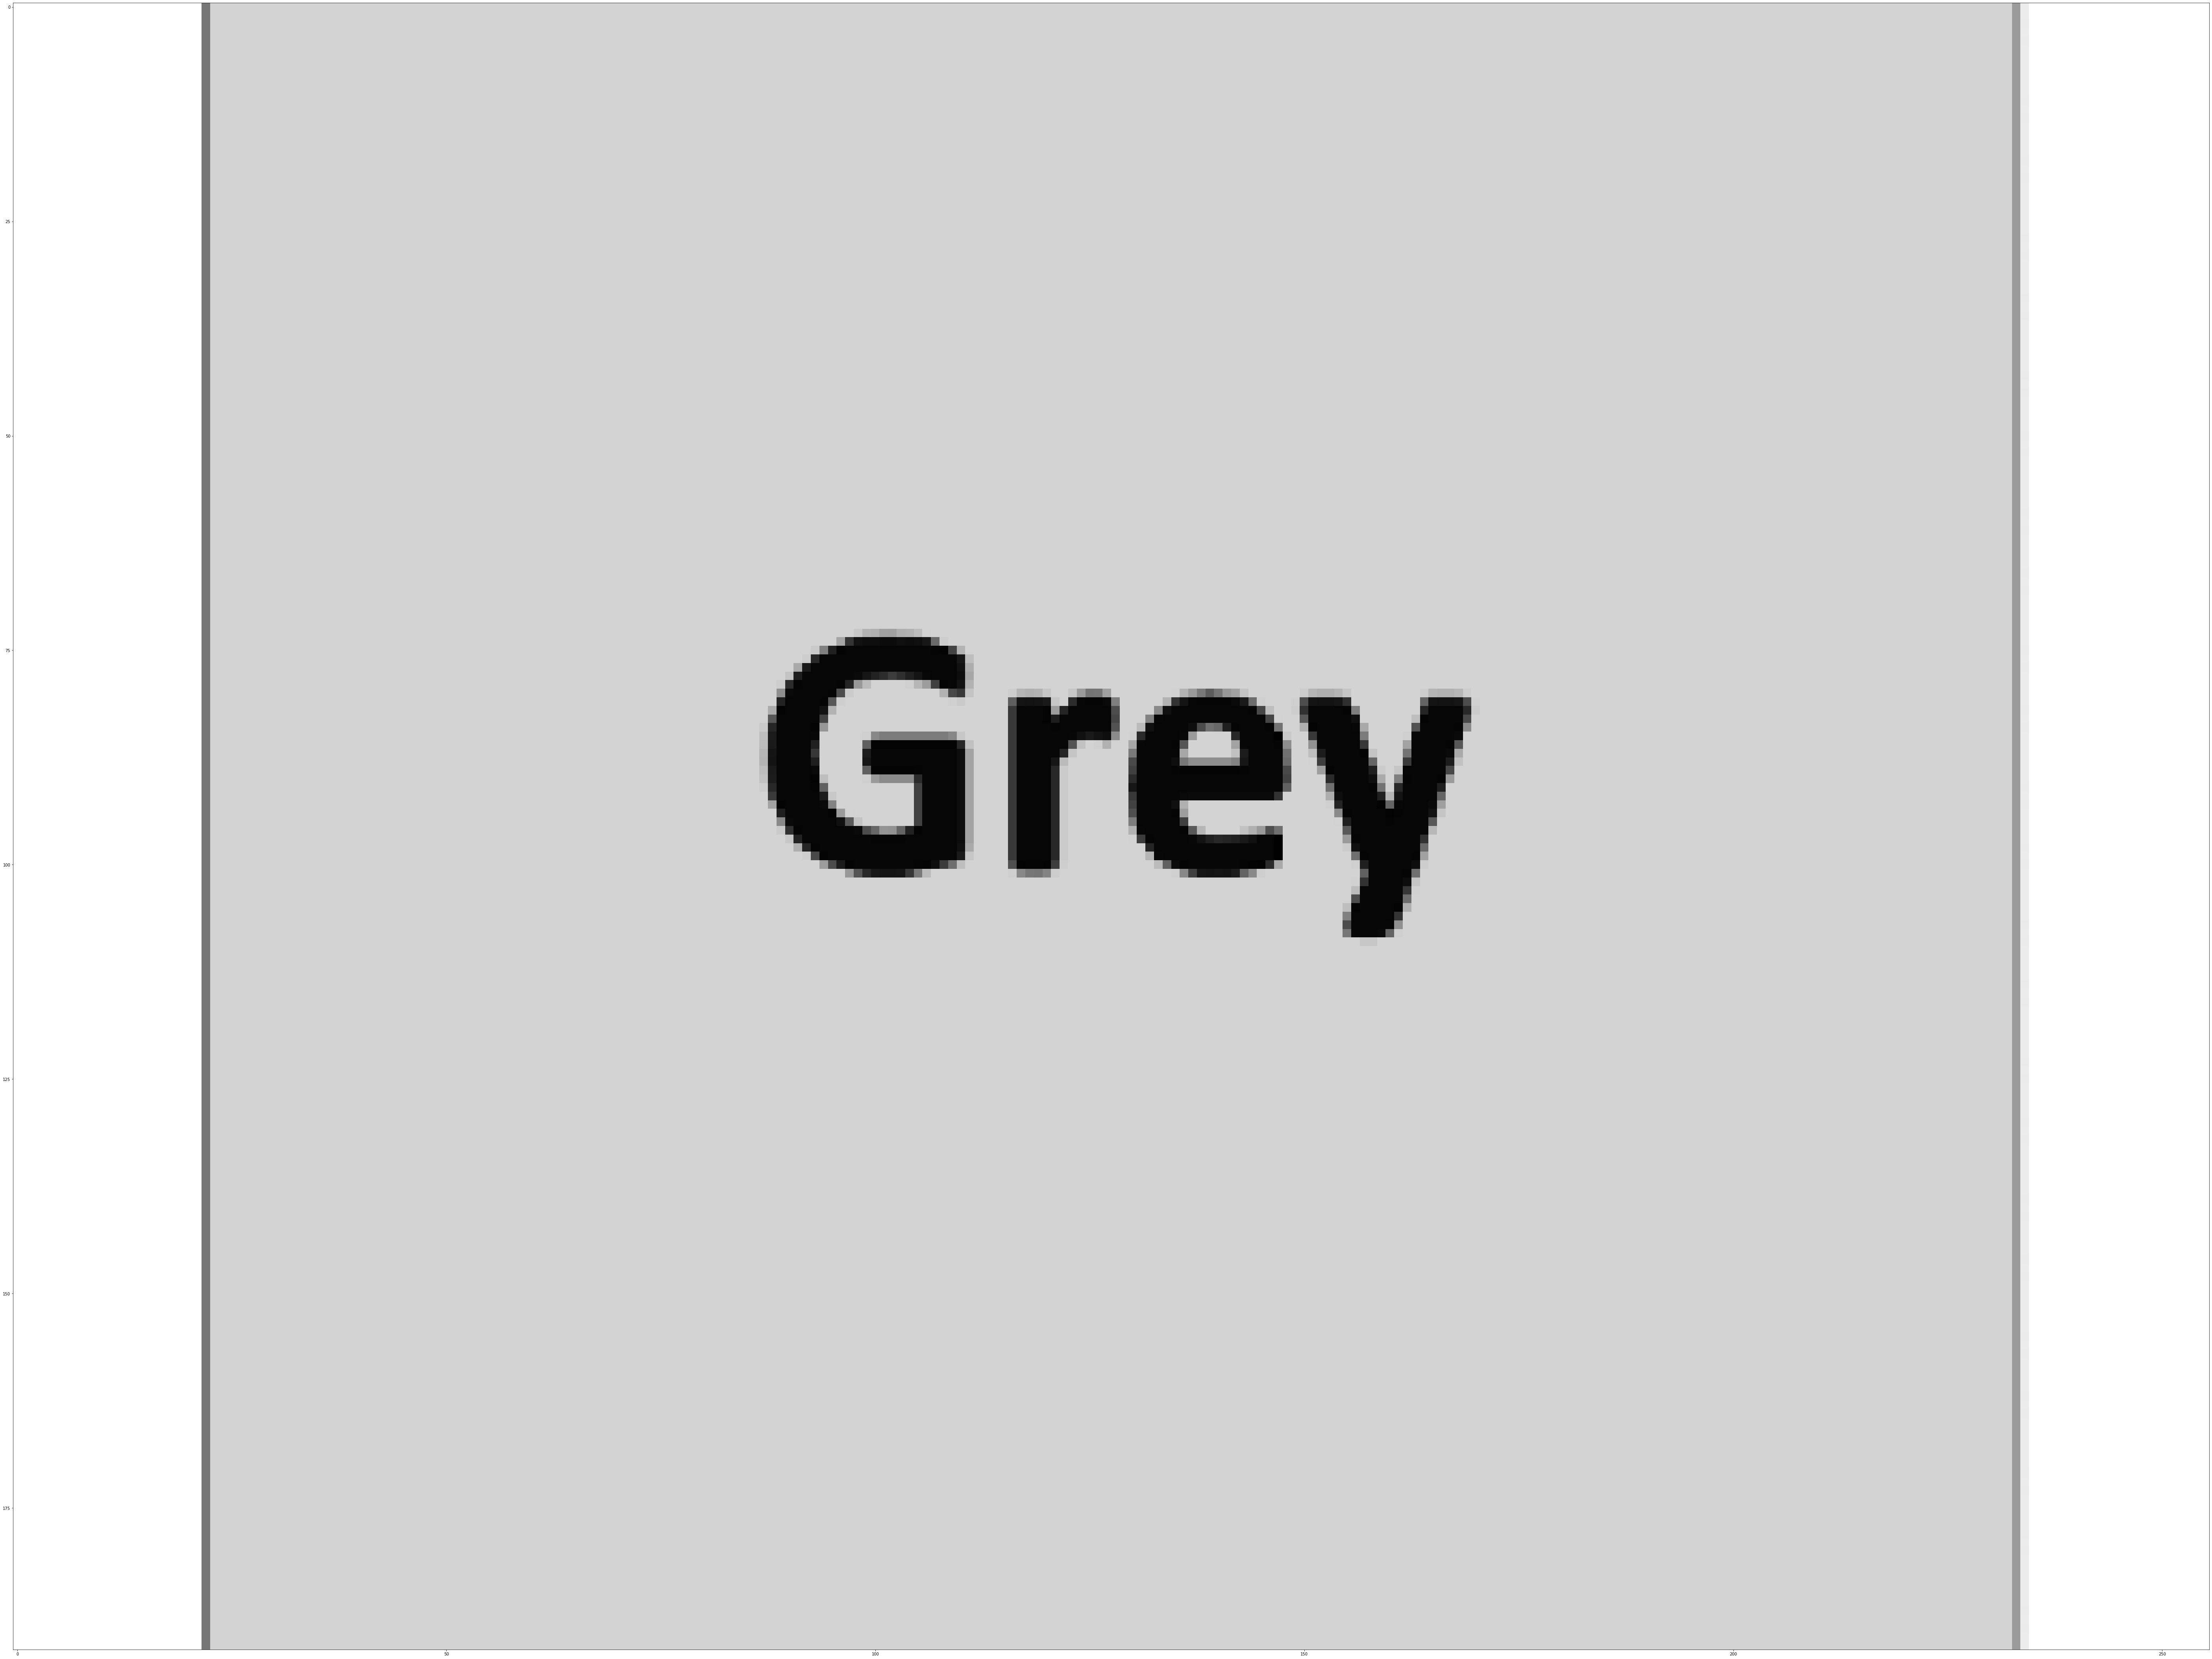

In [ ]:
filenames=glob.glob(colours[7]+'/Valid/*.png')
img=load(filenames[0])
img=img.reshape(h,b)
plt.figure(figsize=(100,100))
plt.imshow(img,cmap='gray')

In [ ]:
m_train=20000
m_valid=2000

In [ ]:
train_data_gen=ImageDataGenerator(
    height_shift_range=0.2,
    width_shift_range=0.05,
    rotation_range=5,
    fill_mode='constant',
    cval=255.0,                                                
    #zoom_range=[0.9,1.1],                     
)

valid_data_gen=ImageDataGenerator(
    height_shift_range=0.1,
    width_shift_range=0.01,
    rotation_range=5,
    fill_mode='constant',
    cval=255.0,                                                
    #zoom_range=[0.3,0.6],                      
)

In [ ]:
X_train=np.zeros([m_train,h,b,1])
y_train=np.zeros([m_train,1])

img_ind=0
for i in range(8) :

  filenames=glob.glob(colours[i]+'/*.png')
  m=len(filenames)

  train_X=np.zeros([m,h,b,1])
  train_y=np.zeros([m,1])

  ind=0
  for image_name in filenames :
     train_X[ind]=load(image_name)
     train_y[ind]=i
     ind+=1

  factor=int(m_train/(8*m))
  for i in range(factor):                                                    
      it=train_data_gen.flow(train_X,train_y,batch_size=m)                        
      temp=next(it)
      X_train[img_ind+i*m:img_ind+(i+1)*m,:,:,:]=temp[0]                                 
      y_train[img_ind+i*m:img_ind+(i+1)*m,:]=temp[1]

  img_ind+=m*factor

  


In [ ]:
X_valid=np.zeros([m_valid,h,b,1])
y_valid=np.zeros([m_valid,1])

img_ind=0
for i in range(8) :

  filenames=glob.glob(colours[i]+'/Valid/*.png')
  m=len(filenames)

  valid_X=np.zeros([m,h,b,1])
  valid_y=np.zeros([m,1])

  ind=0
  for image_name in filenames :
     valid_X[ind]=load(image_name)
     valid_y[ind]=i
     ind+=1

  factor=int(m_valid/(8*m))
  for i in range(factor):                                                    
      it=valid_data_gen.flow(valid_X,valid_y,batch_size=m)                        
      temp=next(it)
      X_valid[img_ind+i*m:img_ind+(i+1)*m,:,:,:]=temp[0]                                 
      y_valid[img_ind+i*m:img_ind+(i+1)*m,:]=temp[1]

  img_ind+=m*factor

  


In [ ]:
pos=np.arange(len(y_train))
np.random.shuffle(pos)          
X_train=X_train[pos]
y_train=y_train[pos]

pos=np.arange(len(y_valid))
np.random.shuffle(pos)          
X_valid=X_valid[pos]
y_valid=y_valid[pos]

In [ ]:
%cd '/content/drive/My Drive/Project_Data/Task_2'

np.save('X_train',X_train)
np.save('y_train',y_train)
np.save('X_valid',X_valid)
np.save('y_valid',y_valid)

/content/drive/.shortcut-targets-by-id/1deNr7eN1qDWU-XvAQGWtSZn6meE_WHre/Project_Data/Task_2


# Load processed data

In [ ]:
%cd '/content/drive/My Drive/Project_Data/Task_2'

X_train=np.load('X_train.npy')
y_train=np.load('y_train.npy')
X_valid=np.load('X_valid.npy')
y_valid=np.load('y_valid.npy')

# Quick peek into some examples

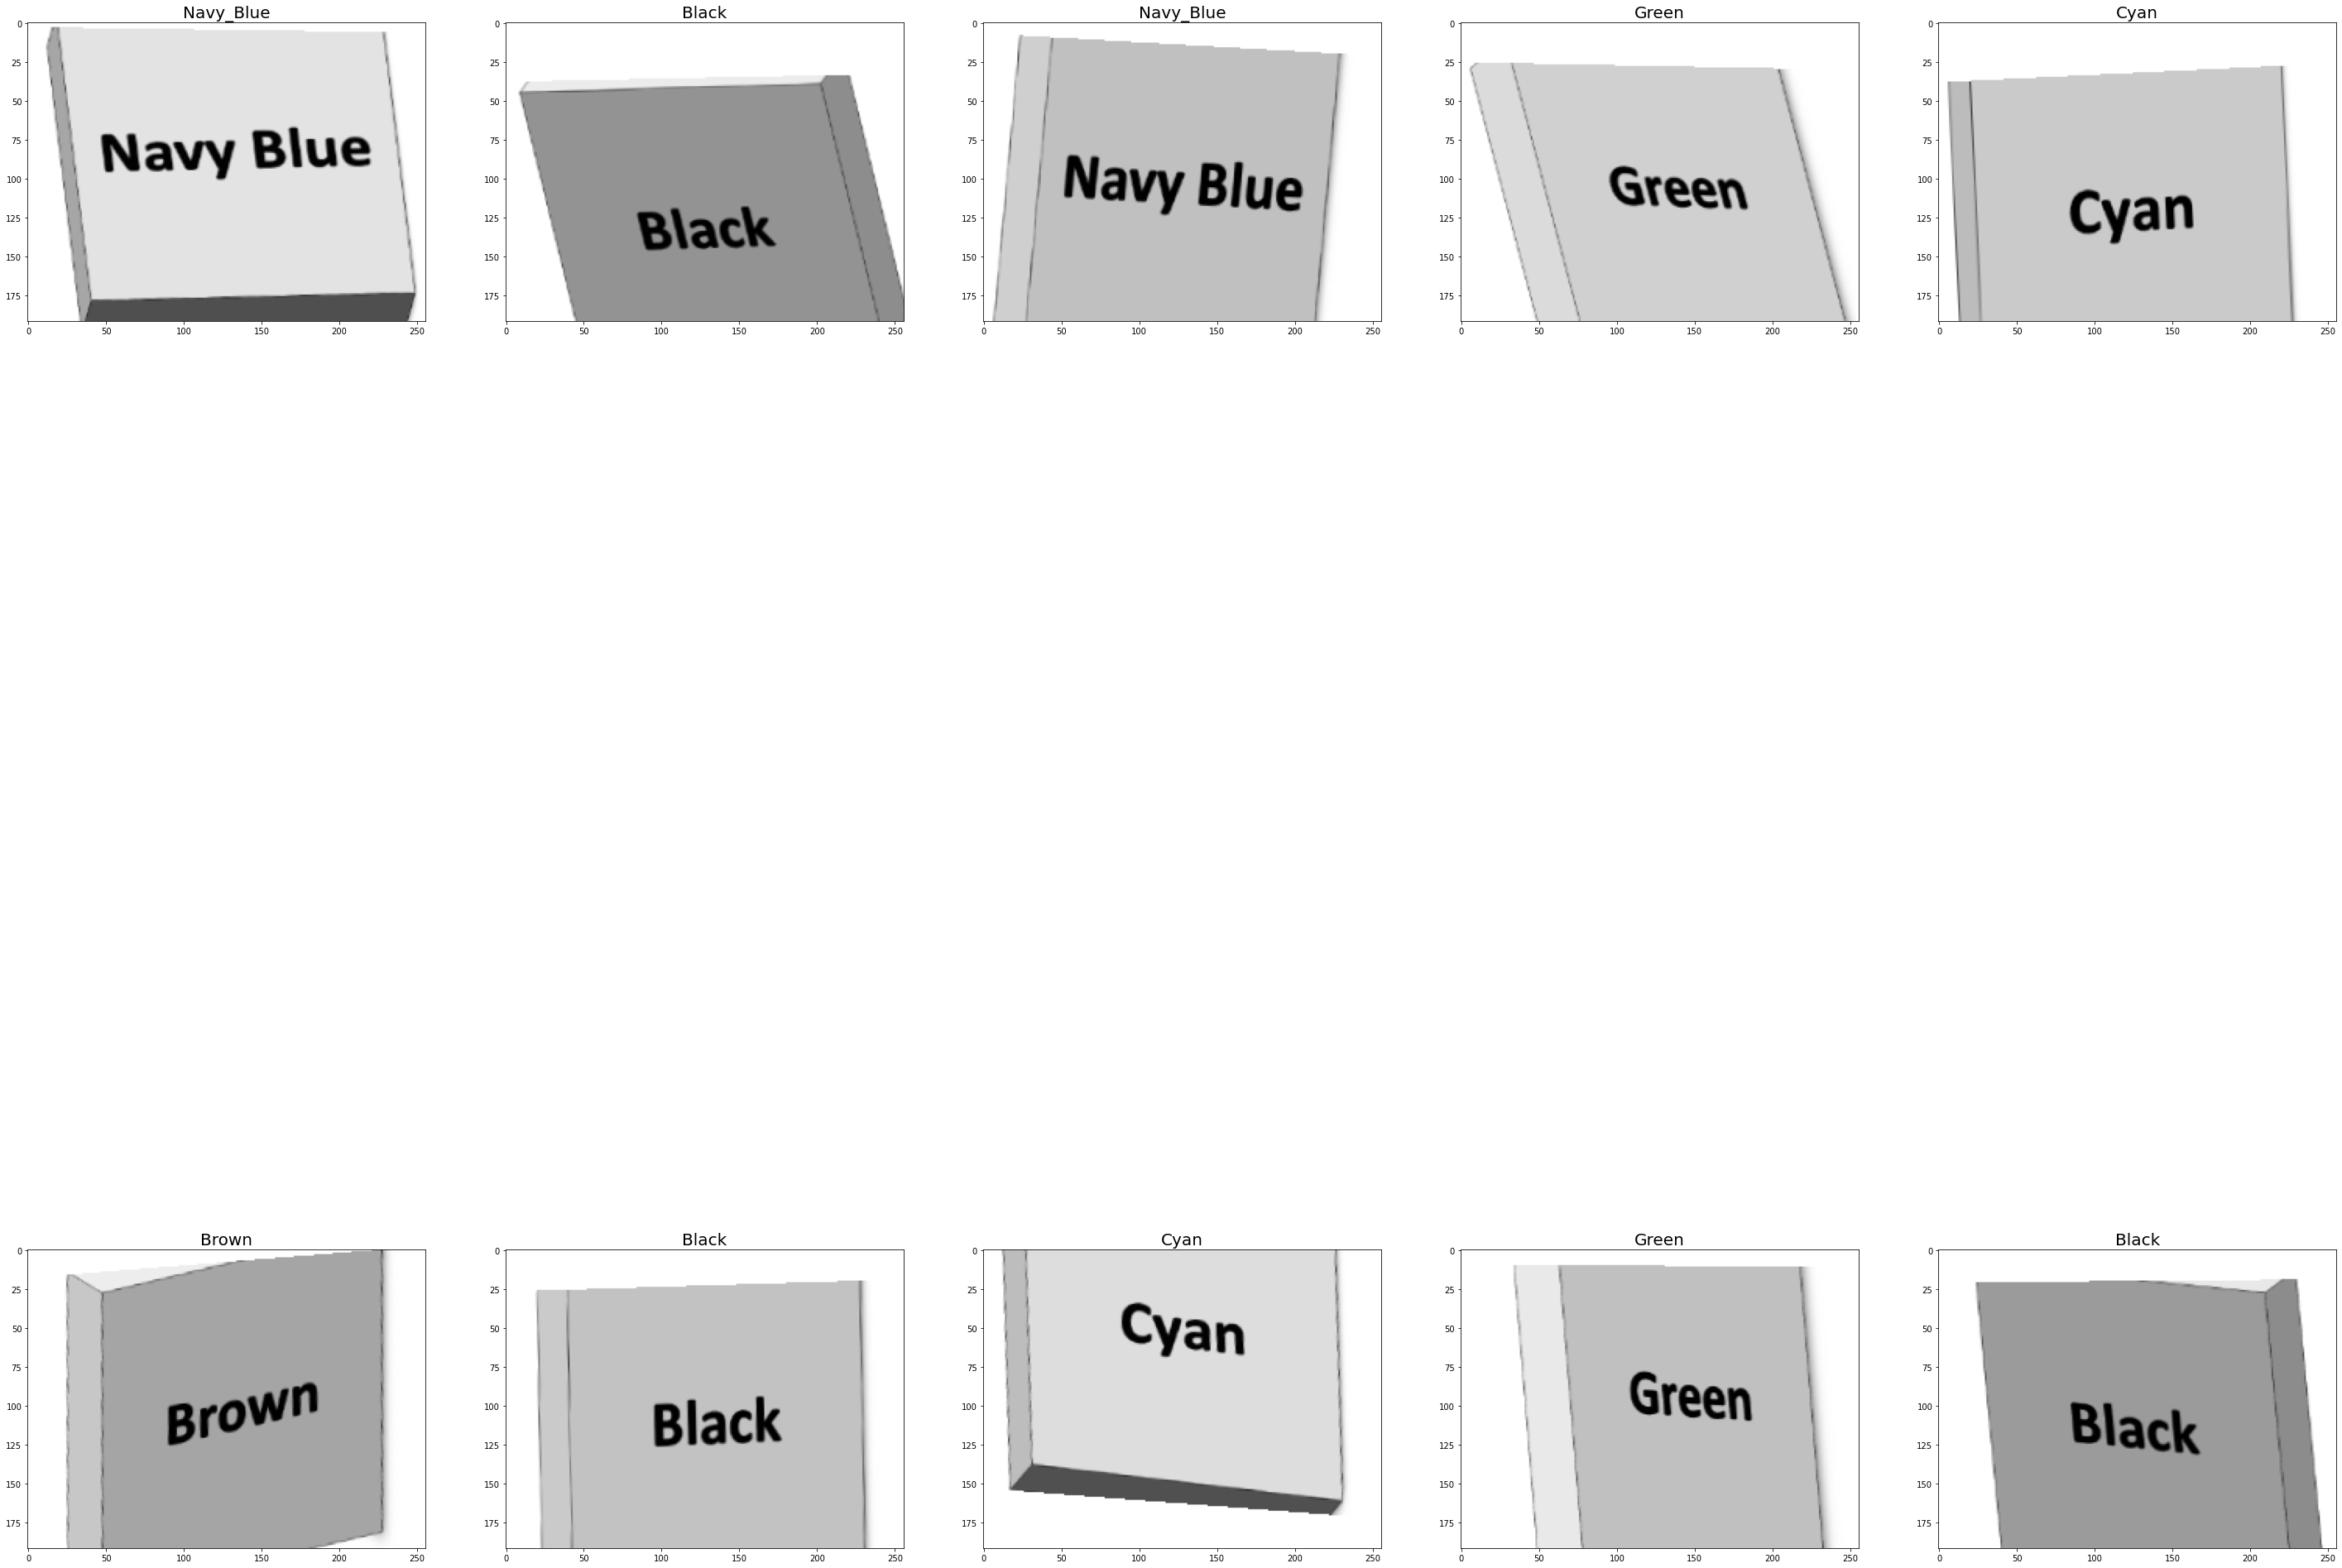

In [ ]:
fig=plt.figure(figsize=(50,50))   
for i in range(10):
  startind=1200
  sub=fig.add_subplot(2,5,i+1)
  img=X_train[i+startind].copy()
  img=img.reshape((h,b))
  sub.imshow(img.astype(np.uint8),cmap='gray')
  #temp=y_train[i]
  plt.title(colours[int(y_train[i+startind])],fontsize=20)        
plt.show()


# Building and training the model

In [ ]:
X_train=X_train/255.0
X_valid=X_valid/255.0

In [ ]:
inputs=tf.keras.Input(shape=(h,b,1))

x=Conv2D(16,3,1,padding='same')(inputs)
x=MaxPool2D(2,2,padding='valid')(x)

x=Conv2D(32,3,1,padding='same')(x)
x=MaxPool2D(2,2,padding='valid')(x)

x=Conv2D(64,3,1,padding='same')(x)
x=BatchNormalization()(x)
x=MaxPool2D(2,2,padding='valid')(x)

x=Conv2D(64,3,1,padding='same')(x)
x=MaxPool2D(2,2,padding='valid')(x)

x=Conv2D(128,3,1,padding='same')(x)
x=MaxPool2D(2,2,padding='valid')(x)

x=Flatten()(x)
output=Dense(8,activation='softmax')(x)

model=tf.keras.Model(inputs,output,name='model1a')

model.compile(optimizer='adagrad',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "model1a"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 192, 256, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 128, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 128, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 64, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 64, 64)        256 

In [ ]:
epochs=20
history=model.fit(X_train,
                  y_train,
                  batch_size=64,
                  epochs=epochs,
                  validation_data=(X_valid,y_valid))

Epoch 1/20
313/313 [==============================] - 10s 31ms/step - loss: 1.2409 - accuracy: 0.5610 - val_loss: 0.6520 - val_accuracy: 0.7725
Epoch 2/20
313/313 [==============================] - 9s 29ms/step - loss: 0.5461 - accuracy: 0.8540 - val_loss: 0.3560 - val_accuracy: 0.8895
Epoch 3/20
313/313 [==============================] - 9s 29ms/step - loss: 0.2957 - accuracy: 0.9423 - val_loss: 0.3053 - val_accuracy: 0.8845
Epoch 4/20
313/313 [==============================] - 9s 29ms/step - loss: 0.1839 - accuracy: 0.9706 - val_loss: 0.1005 - val_accuracy: 0.9900
Epoch 5/20
313/313 [==============================] - 9s 29ms/step - loss: 0.1238 - accuracy: 0.9846 - val_loss: 0.0710 - val_accuracy: 0.9970
Epoch 6/20
313/313 [==============================] - 9s 29ms/step - loss: 0.0898 - accuracy: 0.9913 - val_loss: 0.0606 - val_accuracy: 0.9980
Epoch 7/20
313/313 [==============================] - 9s 29ms/step - loss: 0.0680 - accuracy: 0.9941 - val_loss: 0.0700 - val_accuracy: 0.981

Text(0.5, 1.0, 'Training and Validation Accuracy')

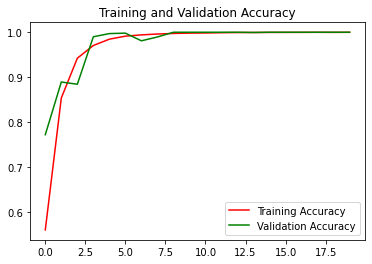

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs_range=range(epochs)
plt.plot(epochs_range, acc, label='Training Accuracy',color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy',color='green')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
predictions=model.predict(X_train).astype(float)
tf.math.confusion_matrix(y_train.reshape(len(y_train),),np.argmax(predictions,axis=1))

<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[2500,    0,    0,    0,    0,    0,    0,    0],
       [   0, 2500,    0,    0,    0,    0,    0,    0],
       [   0,    0, 2500,    0,    0,    0,    0,    0],
       [   0,    0,    0, 2499,    0,    0,    0,    1],
       [   0,    0,    0,    0, 2500,    0,    0,    0],
       [   0,    0,    0,    0,    0, 2500,    0,    0],
       [   0,    0,    0,    0,    0,    0, 2500,    0],
       [   0,    0,    0,    0,    0,    0,    0, 2500]], dtype=int32)>

In [ ]:
model.save("model2_10000.h5")